In [22]:
pip install attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from attention import Attention
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, LSTM,Bidirectional
from pandas import read_csv
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [24]:
df = pd.read_csv(
  "New_york.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [25]:
df.shape

(17356, 9)

In [26]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-01 00:00:00,16,0.24,0.2879,0.81,0.0,1,0,1,1
2017-01-01 01:00:00,40,0.22,0.2727,0.80,0.0,1,0,1,1
2017-01-01 02:00:00,32,0.22,0.2727,0.80,0.0,1,0,1,1
2017-01-01 03:00:00,13,0.24,0.2879,0.75,0.0,1,0,1,1
2017-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1,0,1,1


In [27]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

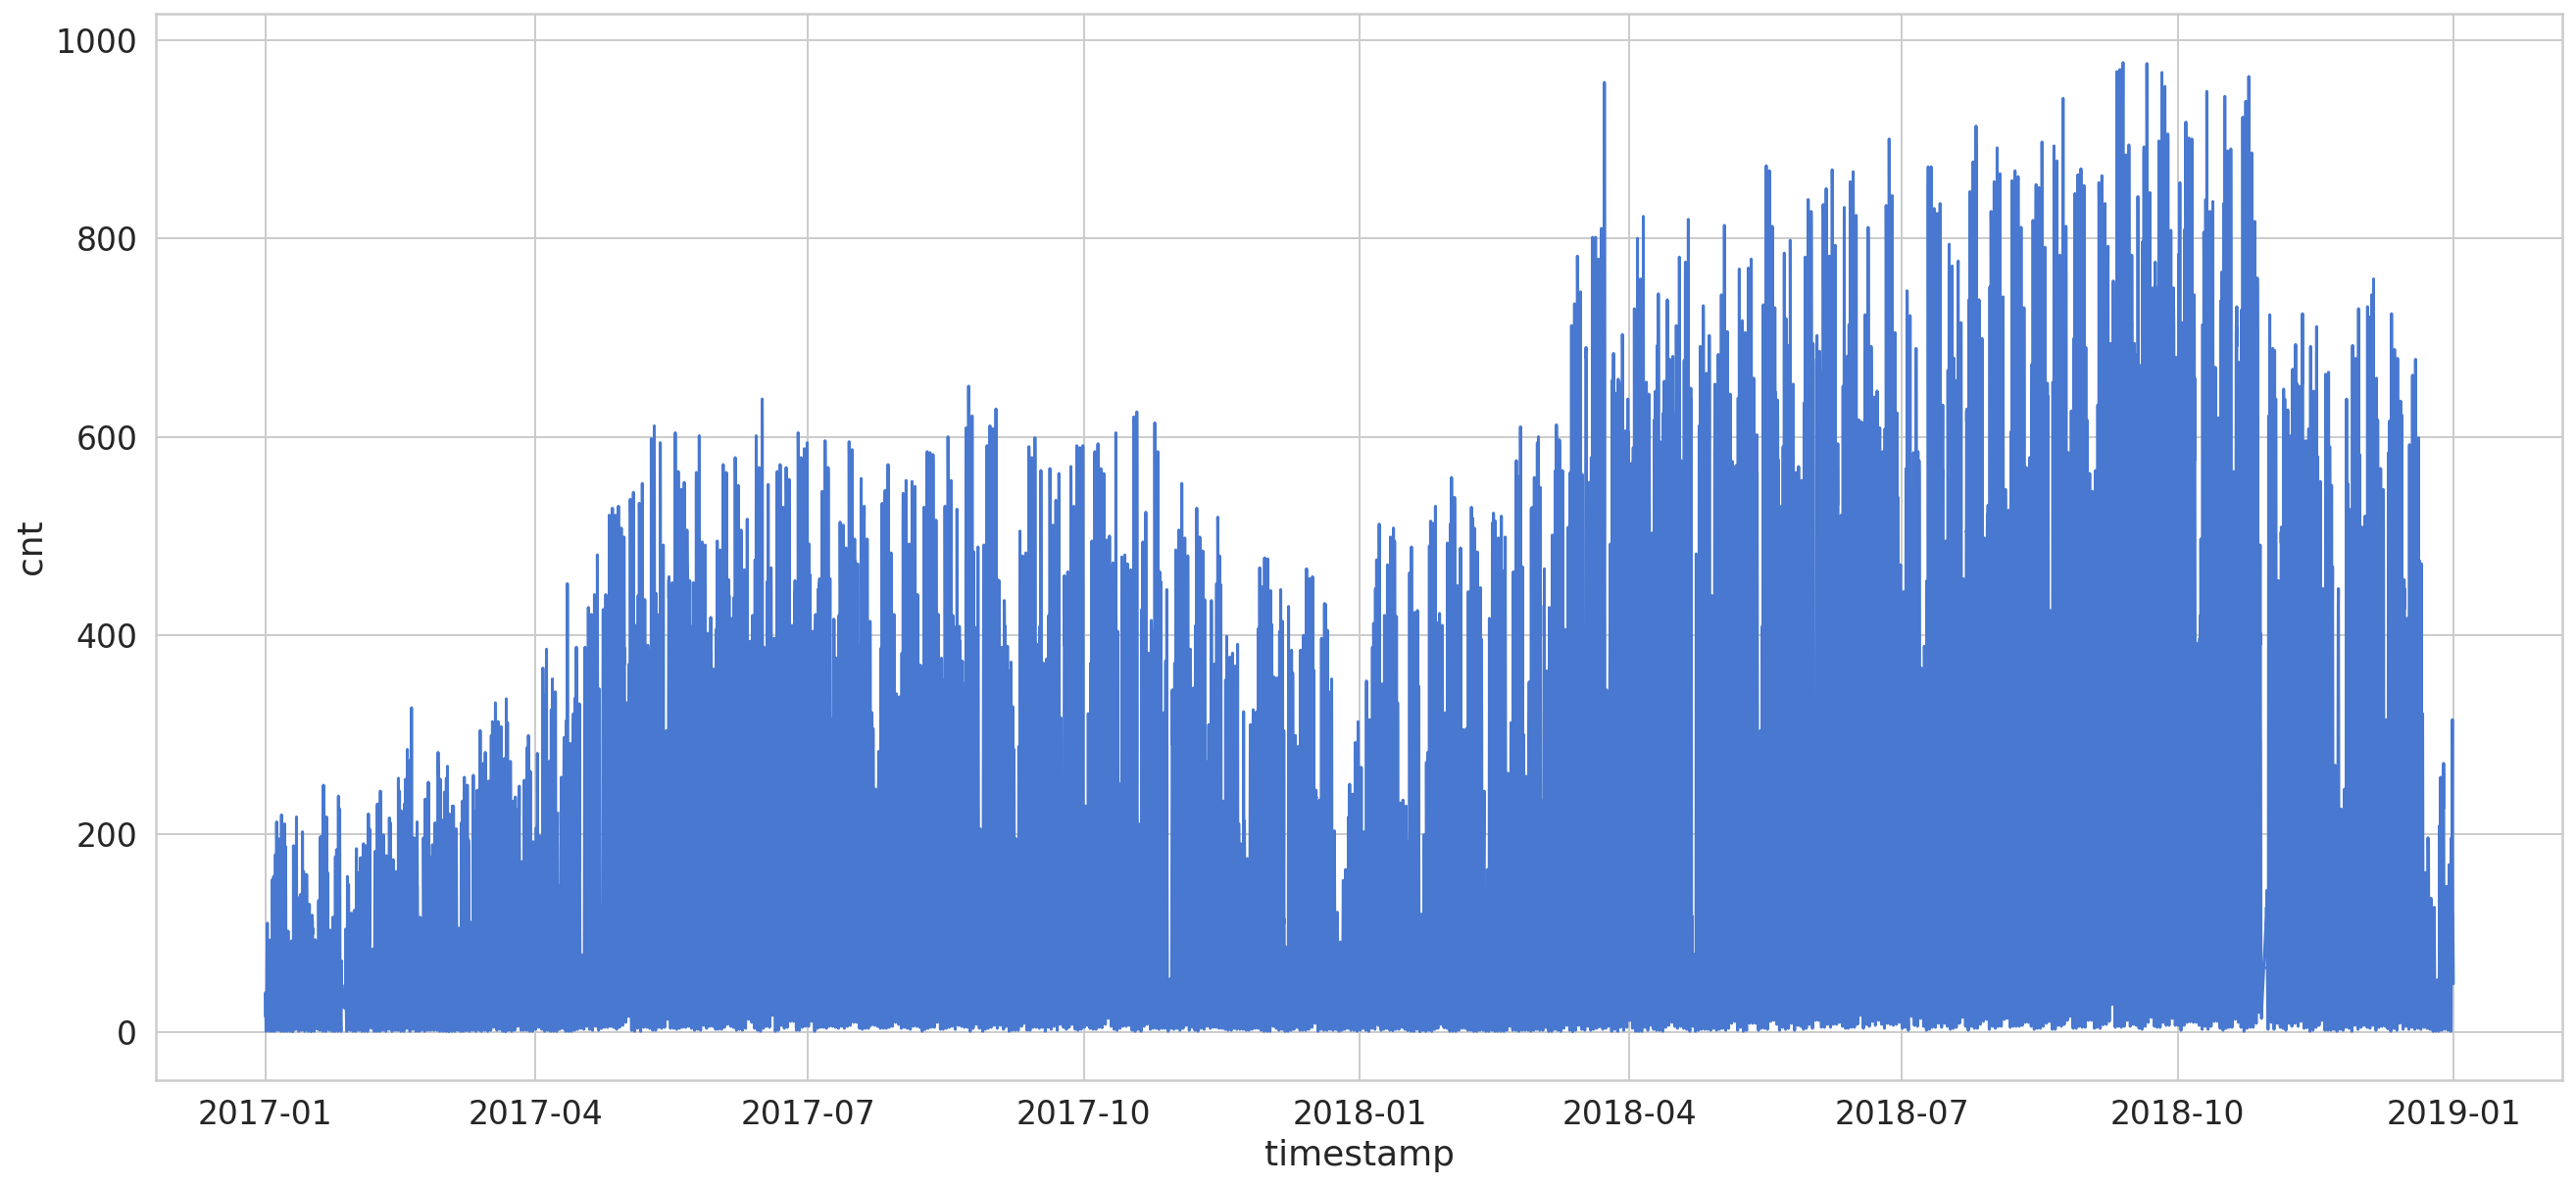

In [28]:
sns.lineplot(x=df.index, y="cnt", data=df);

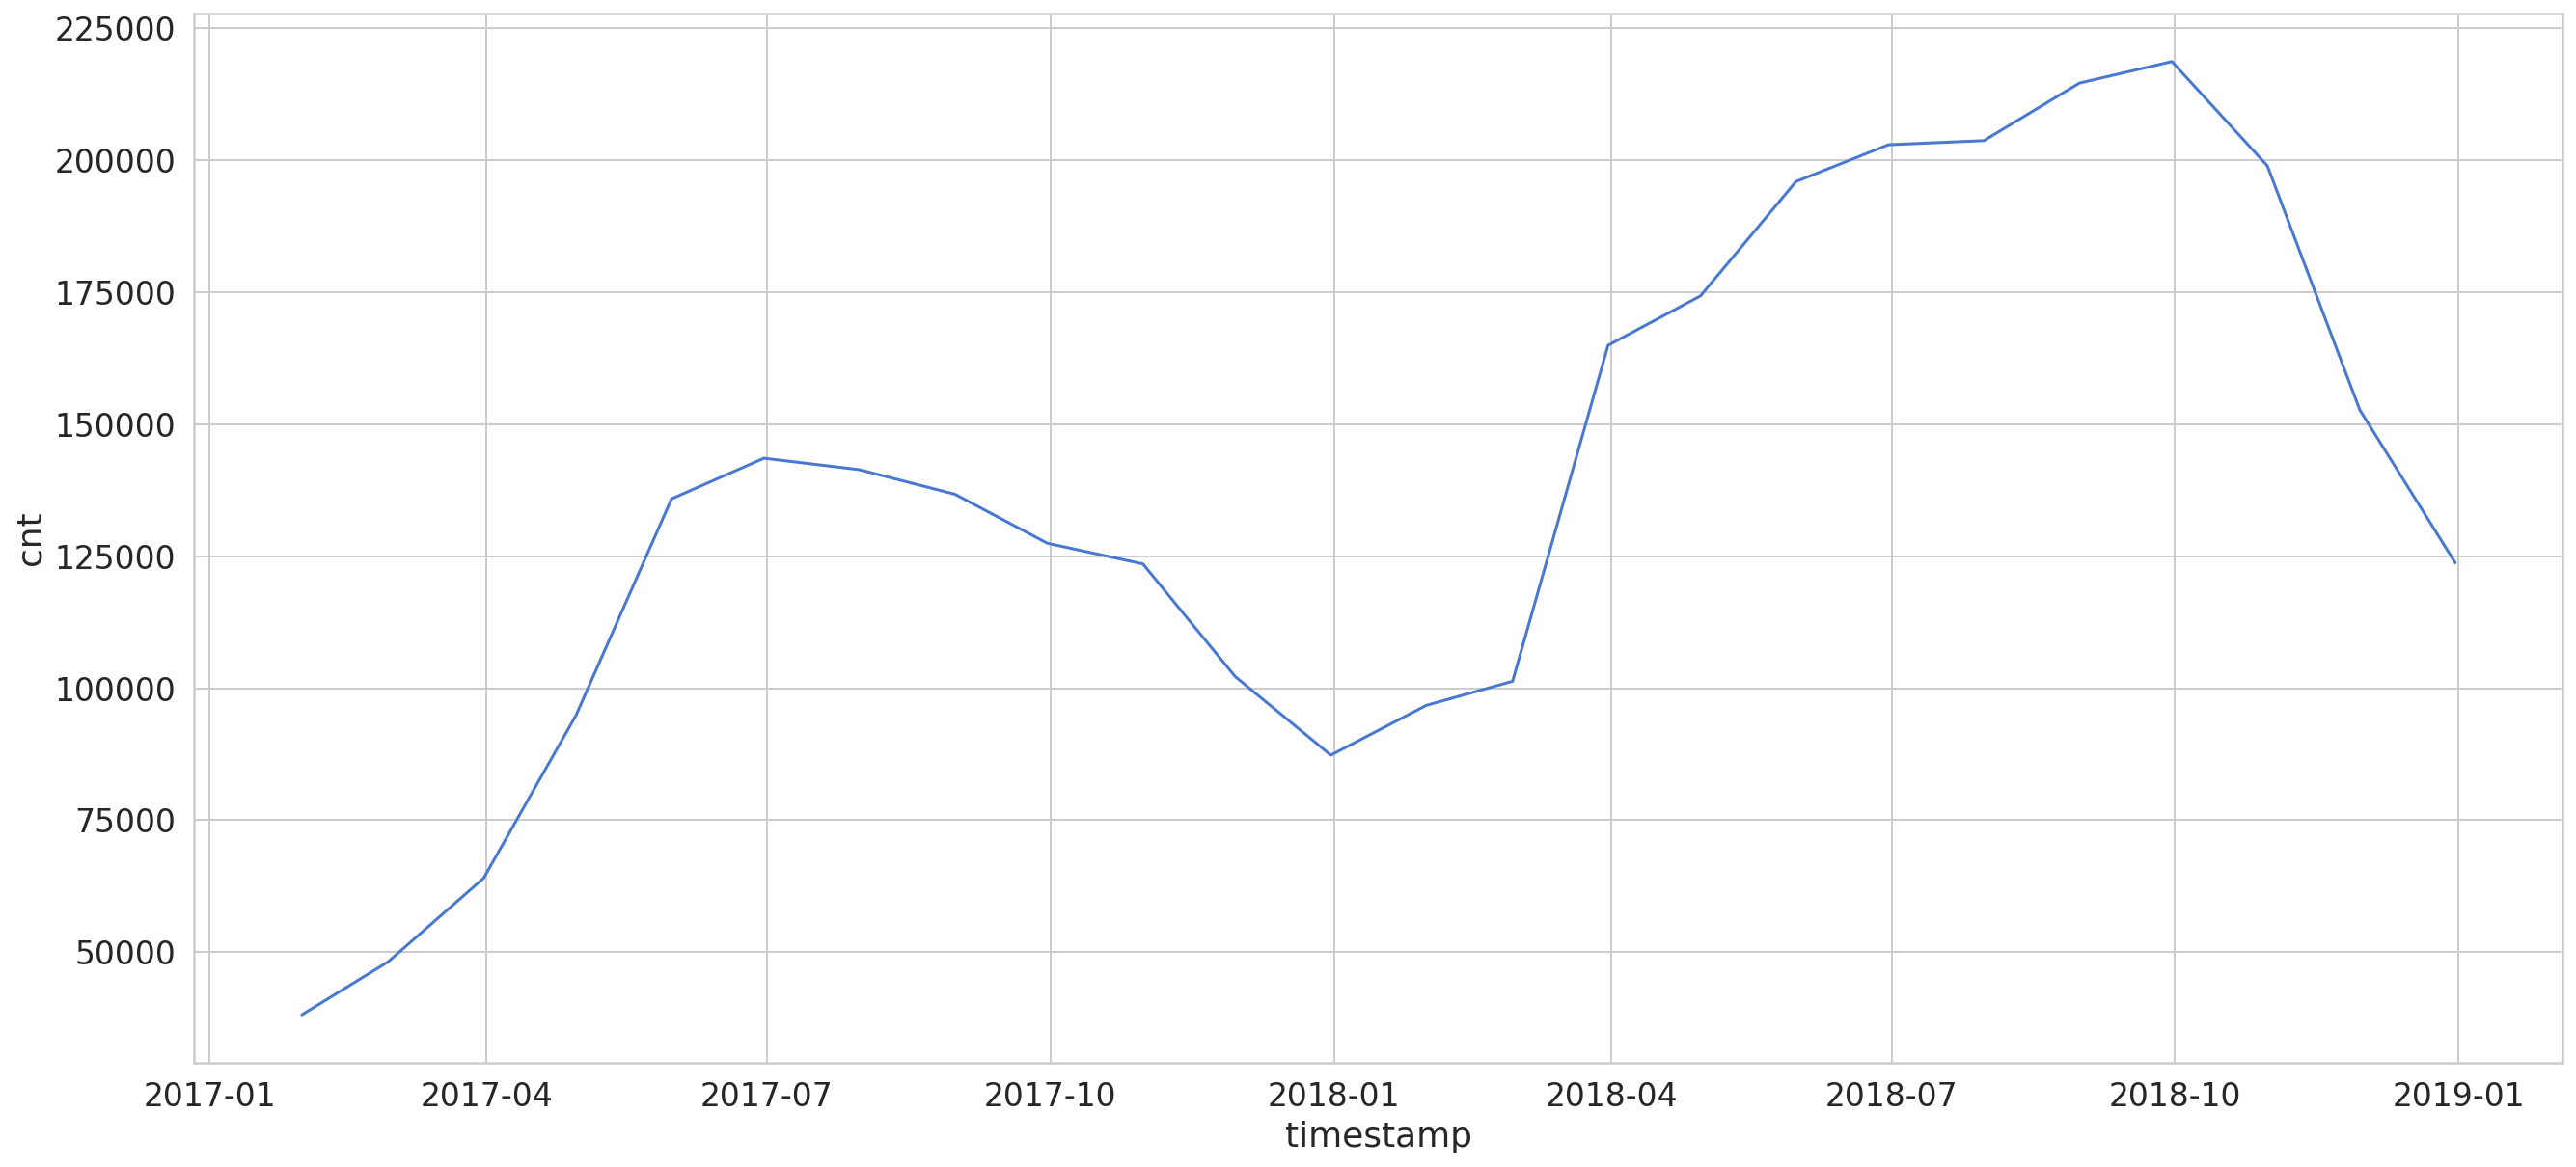

In [29]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

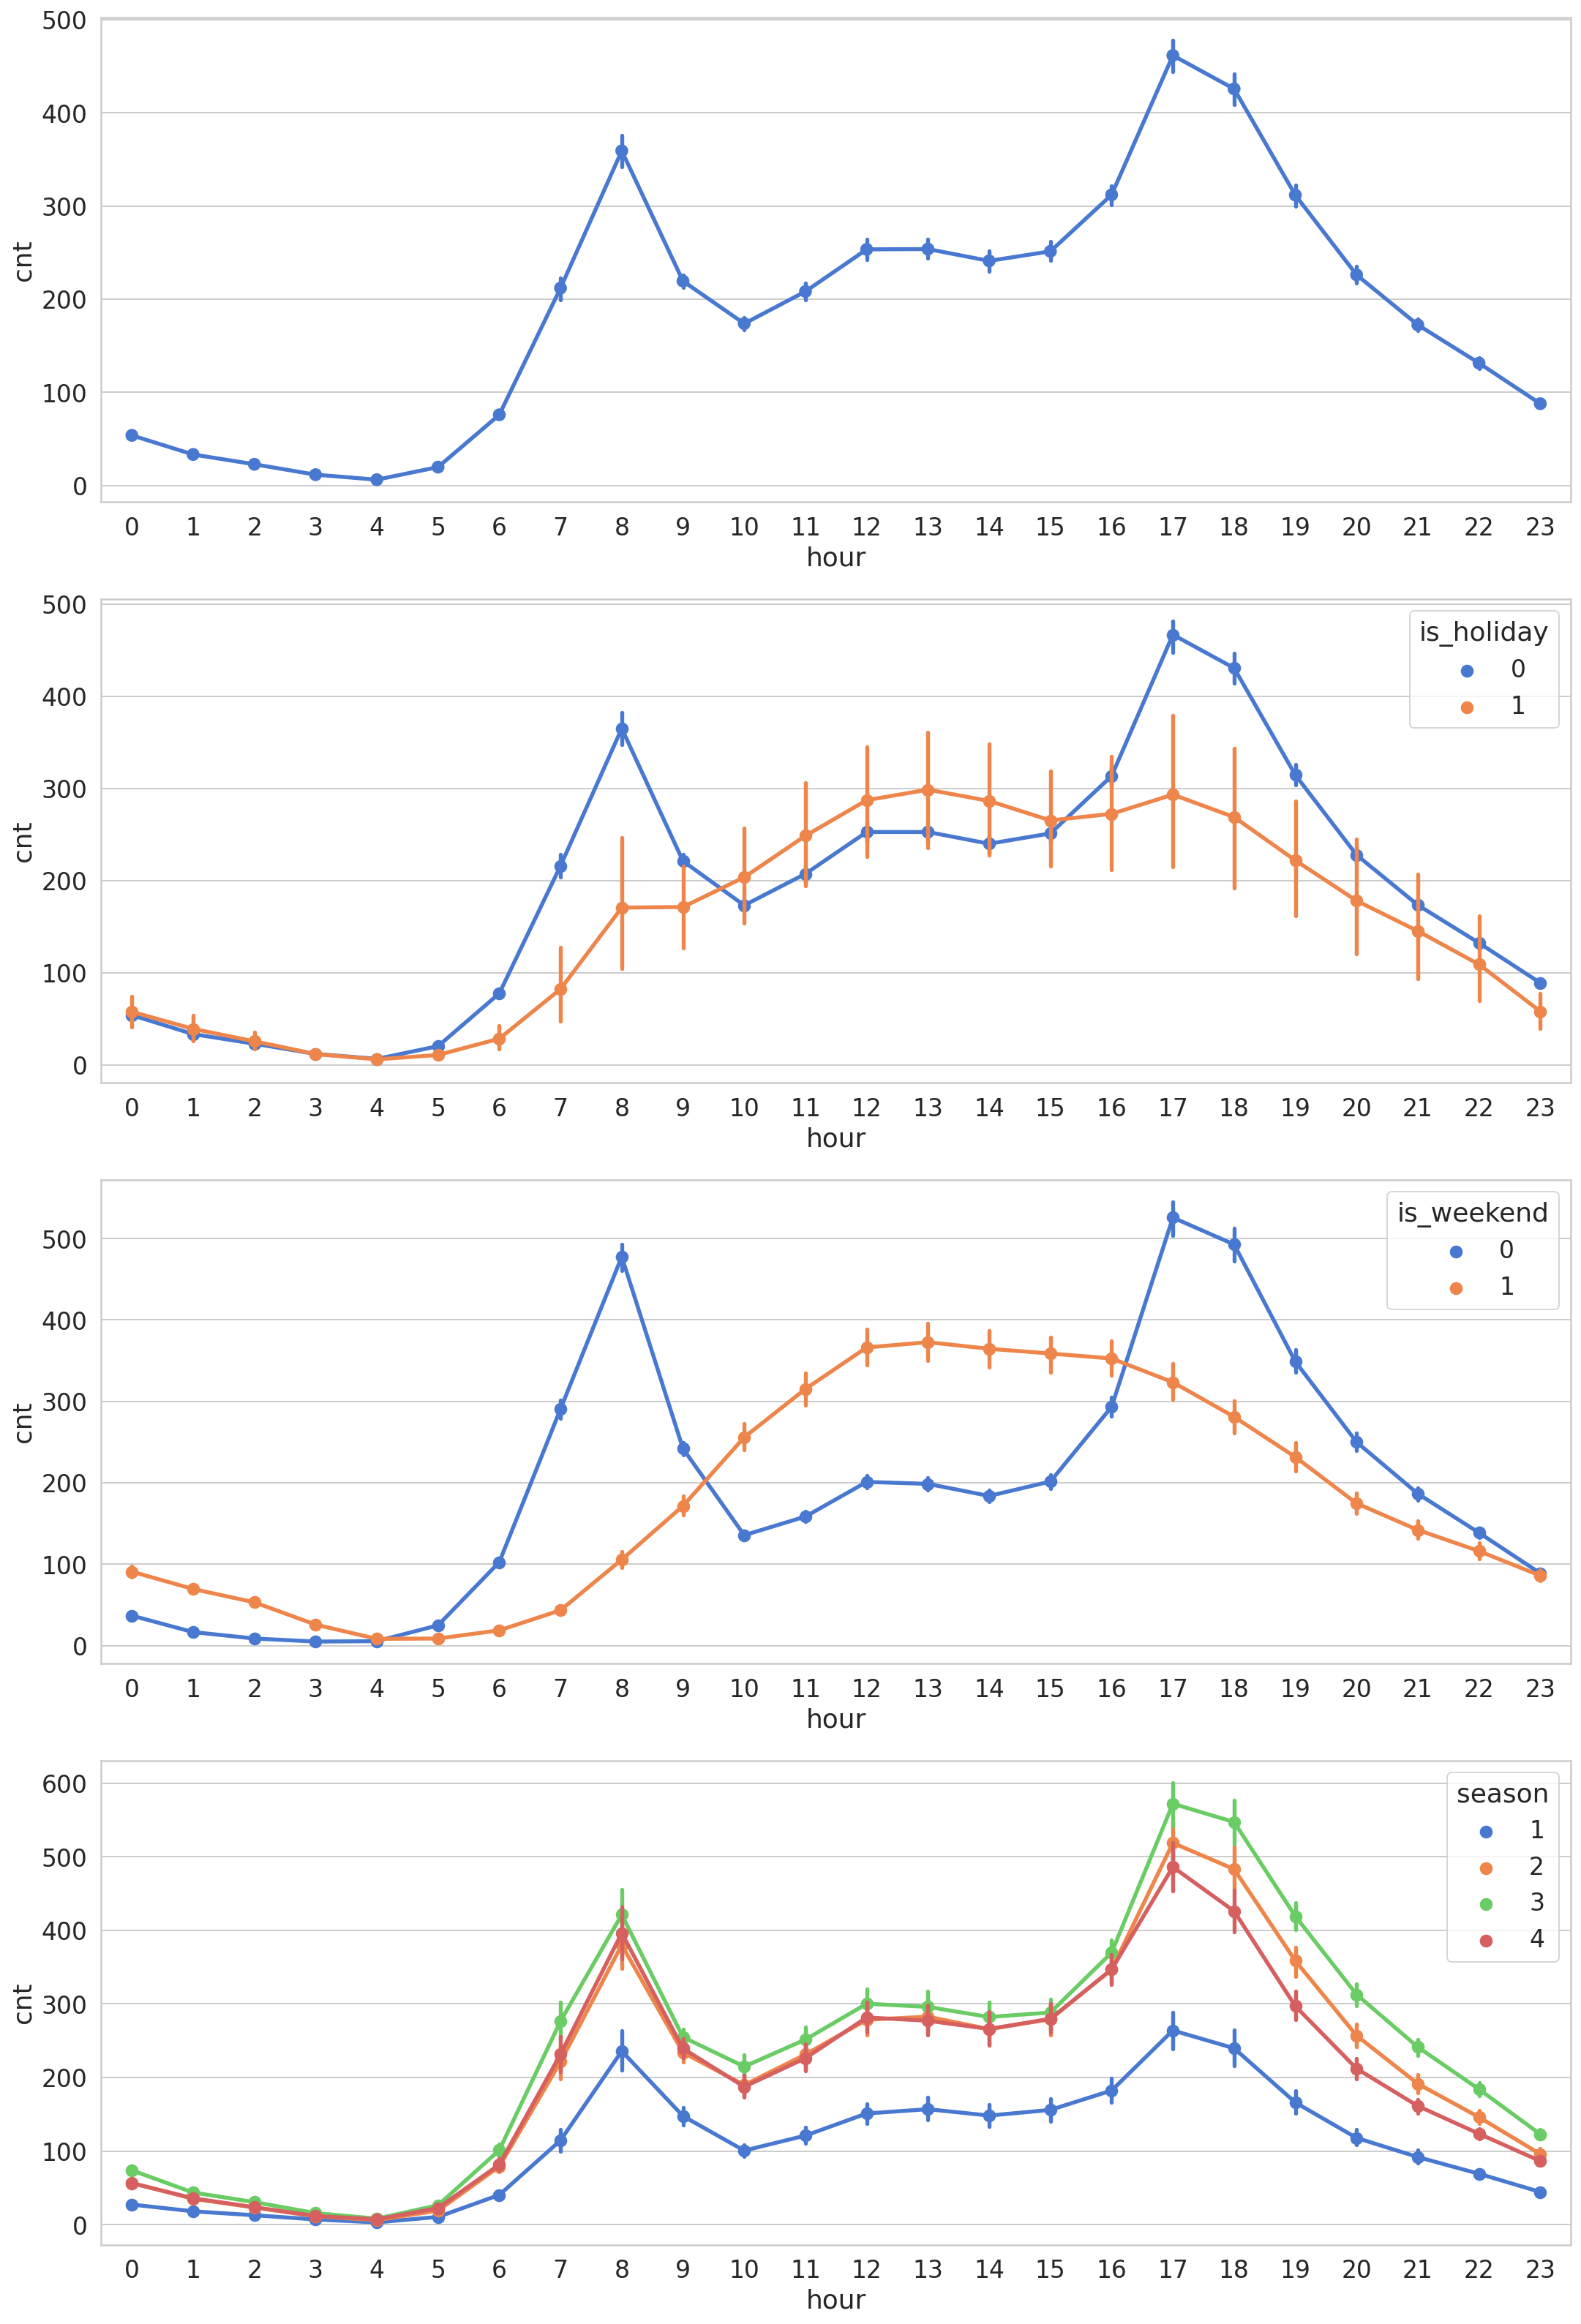

In [30]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

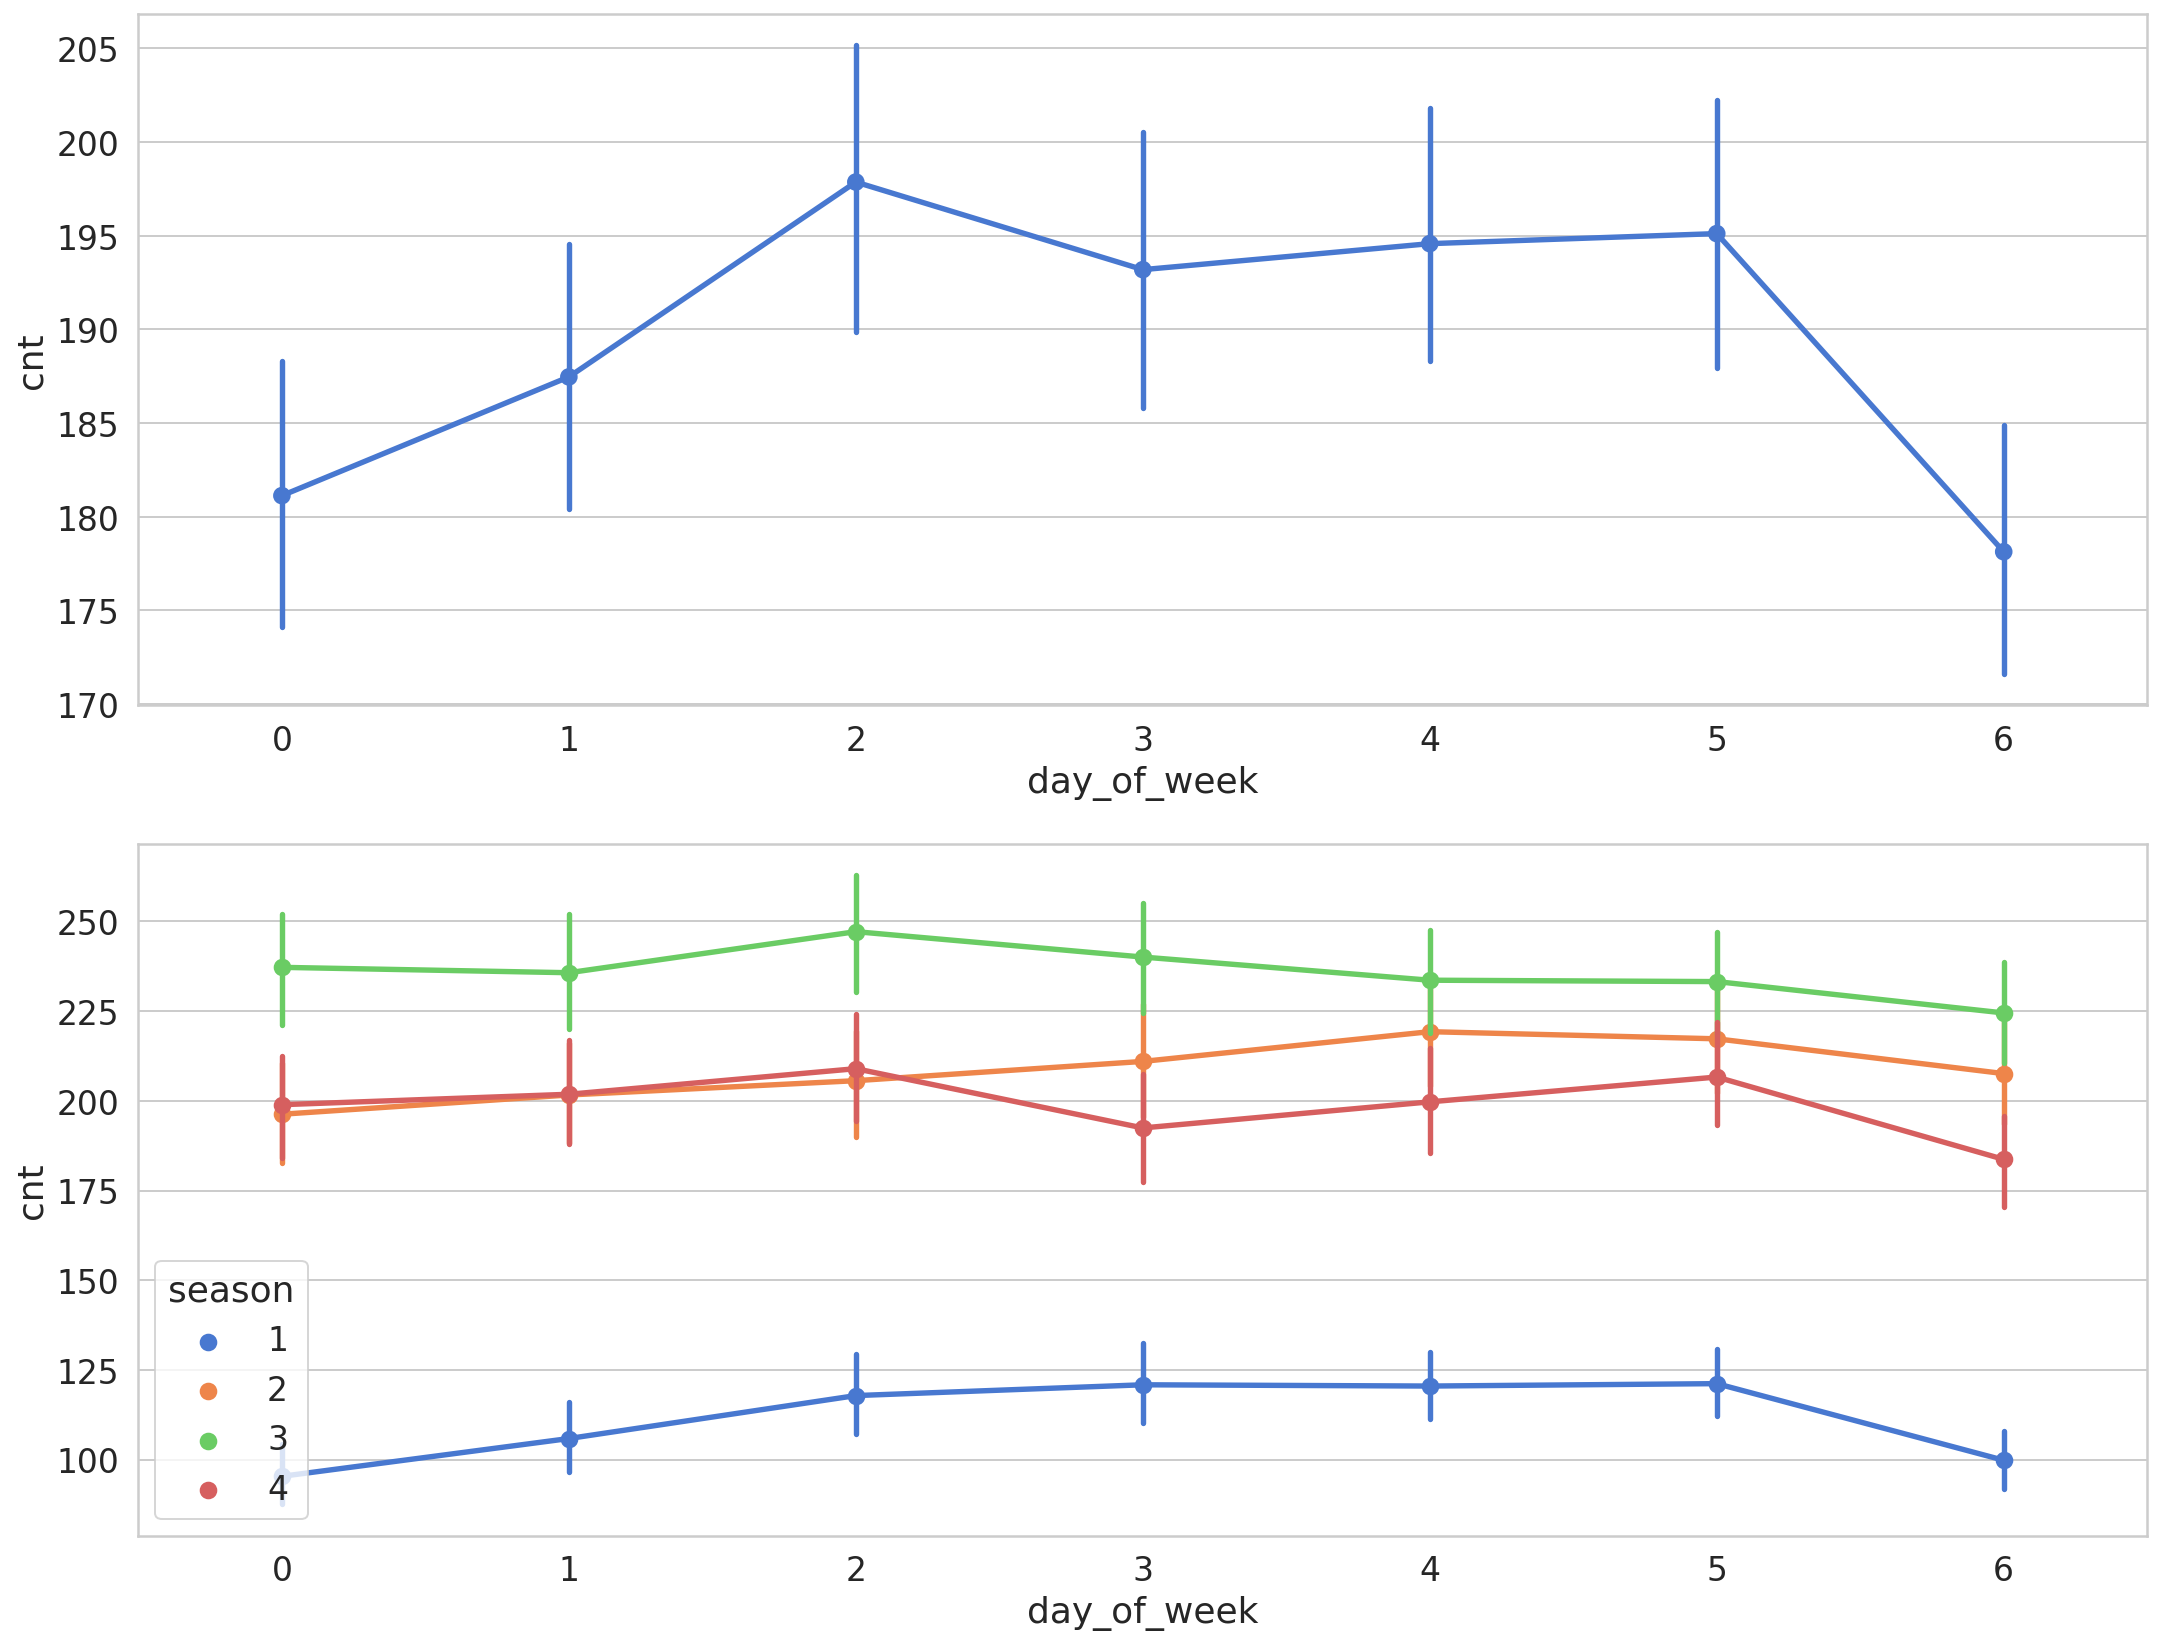

In [31]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [32]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15620 1736


# Preprocessing

In [33]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-33-92b06493bae2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [34]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [35]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15610, 10, 13) (15610,)


In [49]:
from keras import backend as K
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer='adam')
K.set_value(model.optimizer.learning_rate, 0.001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=16, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/200
879/879 [==============================] - 54s 14ms/step - loss: 0.1383 - val_loss: 0.1174
Epoch 2/200
879/879 [==============================] - 12s 13ms/step - loss: 0.0586 - val_loss: 0.0870
Epoch 3/200
879/879 [==============================] - 13s 15ms/step - loss: 0.0452 - val_loss: 0.0676
Epoch 4/200
879/879 [==============================] - 12s 13ms/step - loss: 0.0382 - val_loss: 0.0692
Epoch 5/200
879/879 [==============================] - 12s 14ms/step - loss: 0.0356 - val_loss: 0.0637
Epoch 6/200
879/879 [==============================] - 12s 14ms/step - loss: 0.0326 - val_loss: 0.0544
Epoch 7/200
879/879 [==============================] - 12s 14ms/step - loss: 0.0316 - val_loss: 0.0562
Epoch 8/200
879/879 [==============================] - 12s 13ms/step - loss: 0.0305 - val_loss: 0.0592
Epoch 9/200
879/879 [==============================] - 12s 14ms/step - loss: 0.0288 - val_loss: 0.0547
Epoch 10/200
879/879 [==============================] - 12s 13ms/step - l

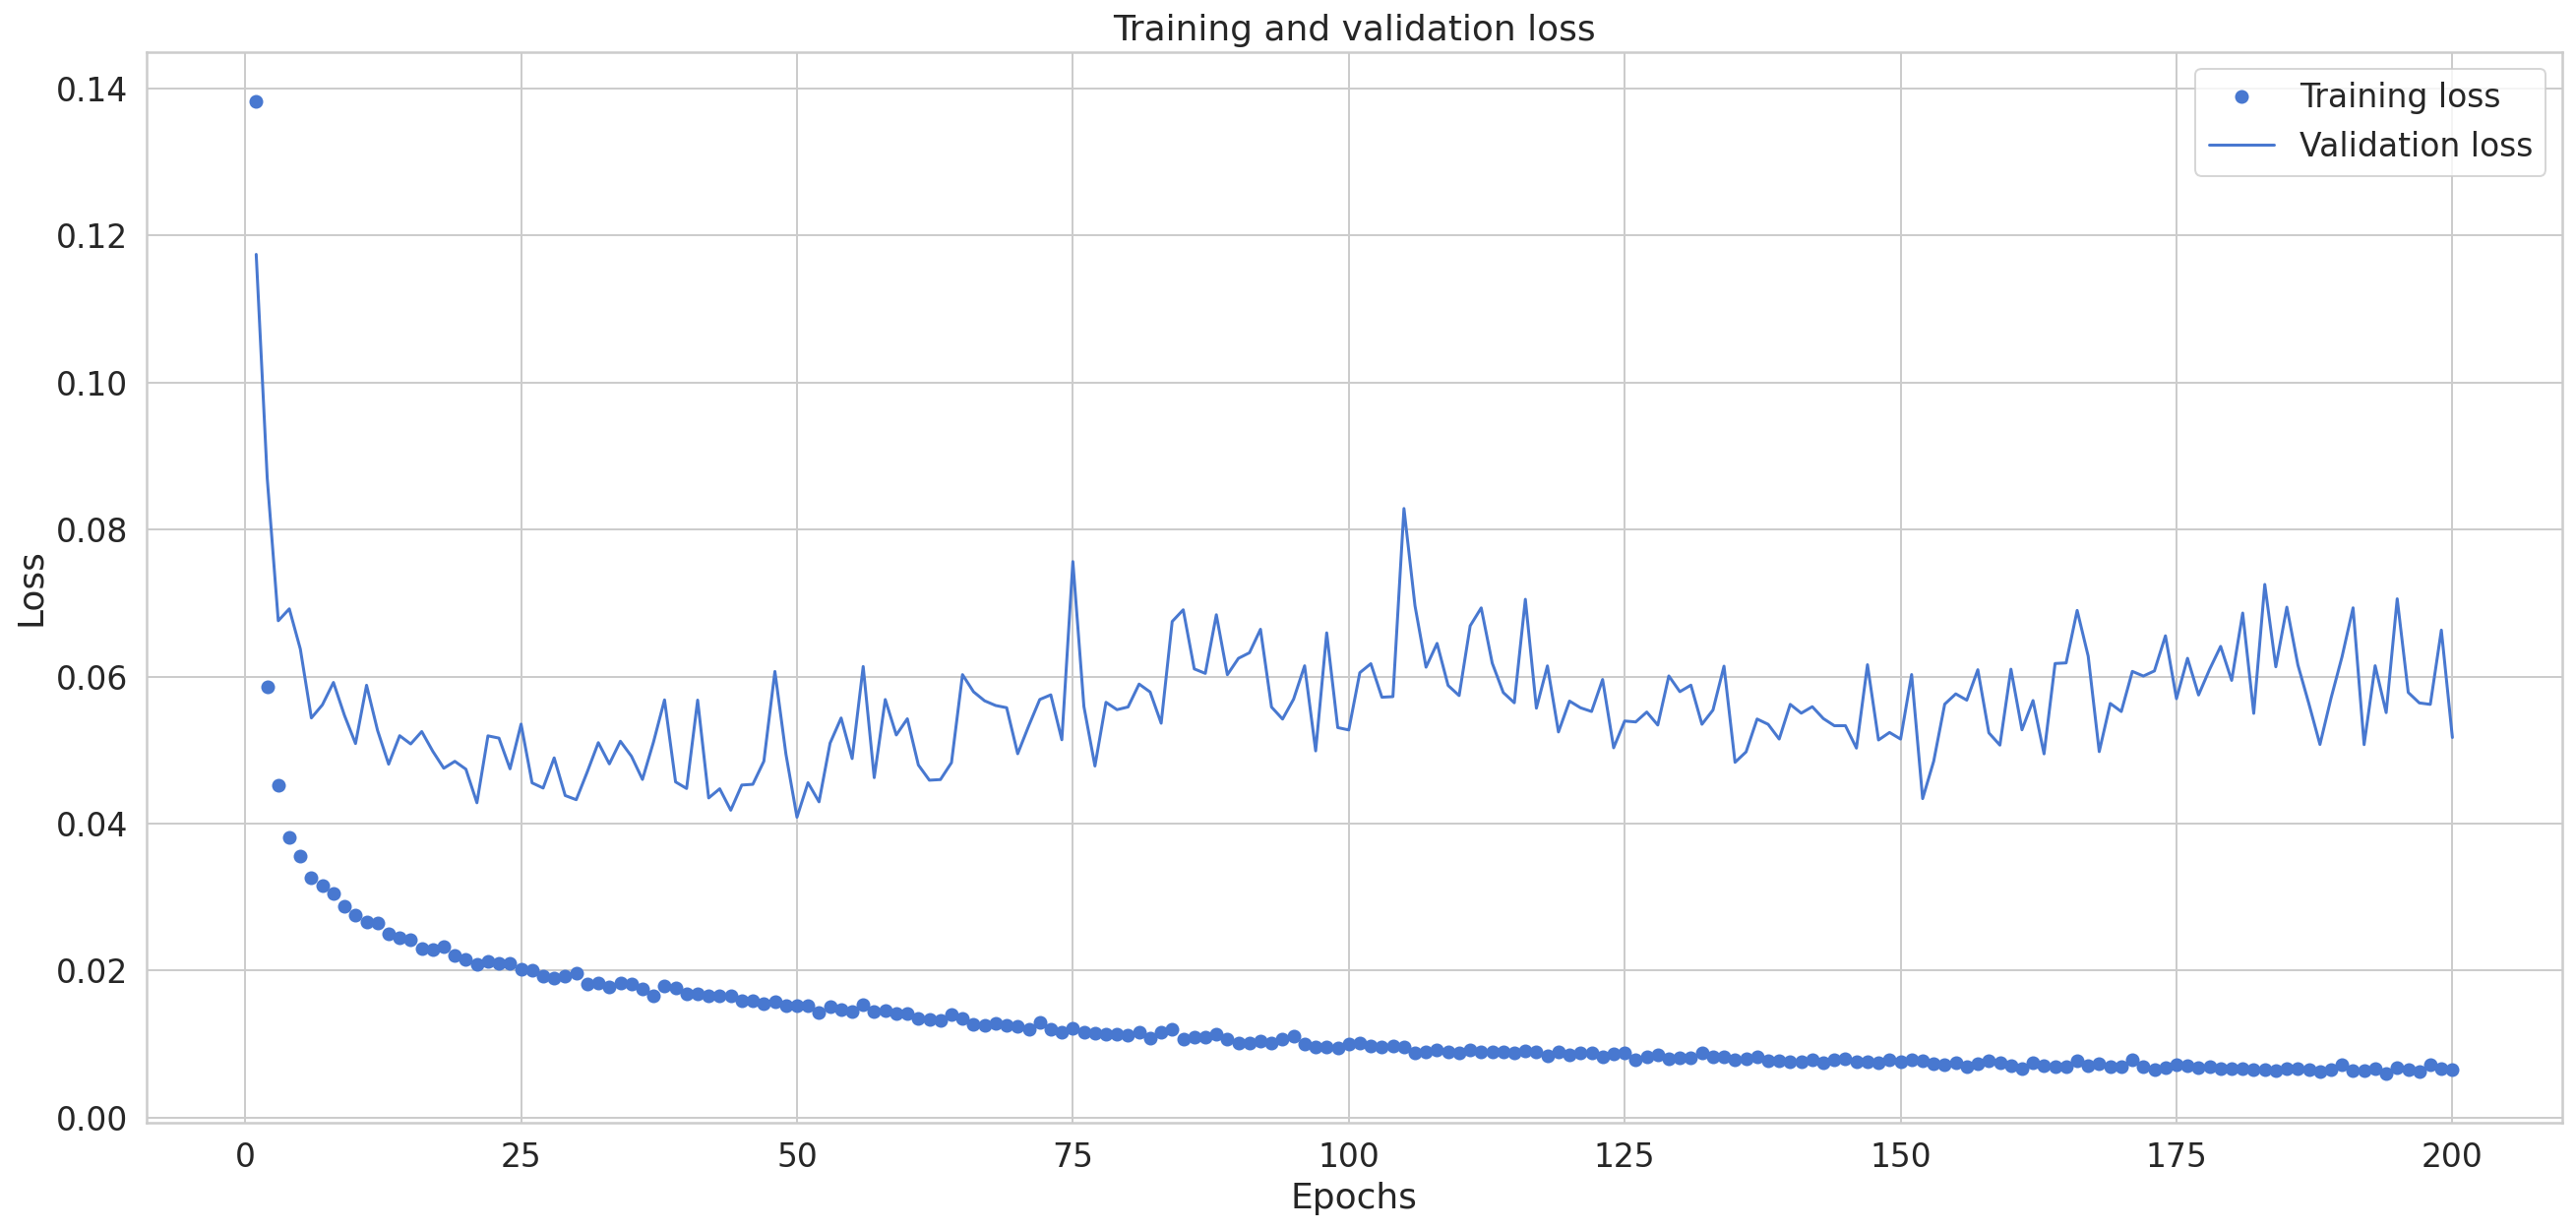

In [51]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(X_test)

54/54 [==============================] - 1s 8ms/step


In [53]:
train_mse = model.evaluate(X_train, y_train)
test_mse = model.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

54/54 [==============================] - 0s 9ms/step - loss: 0.0400
Train set MSE =  0.038584183901548386
Test set MSE =  0.040048059076070786


In [54]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

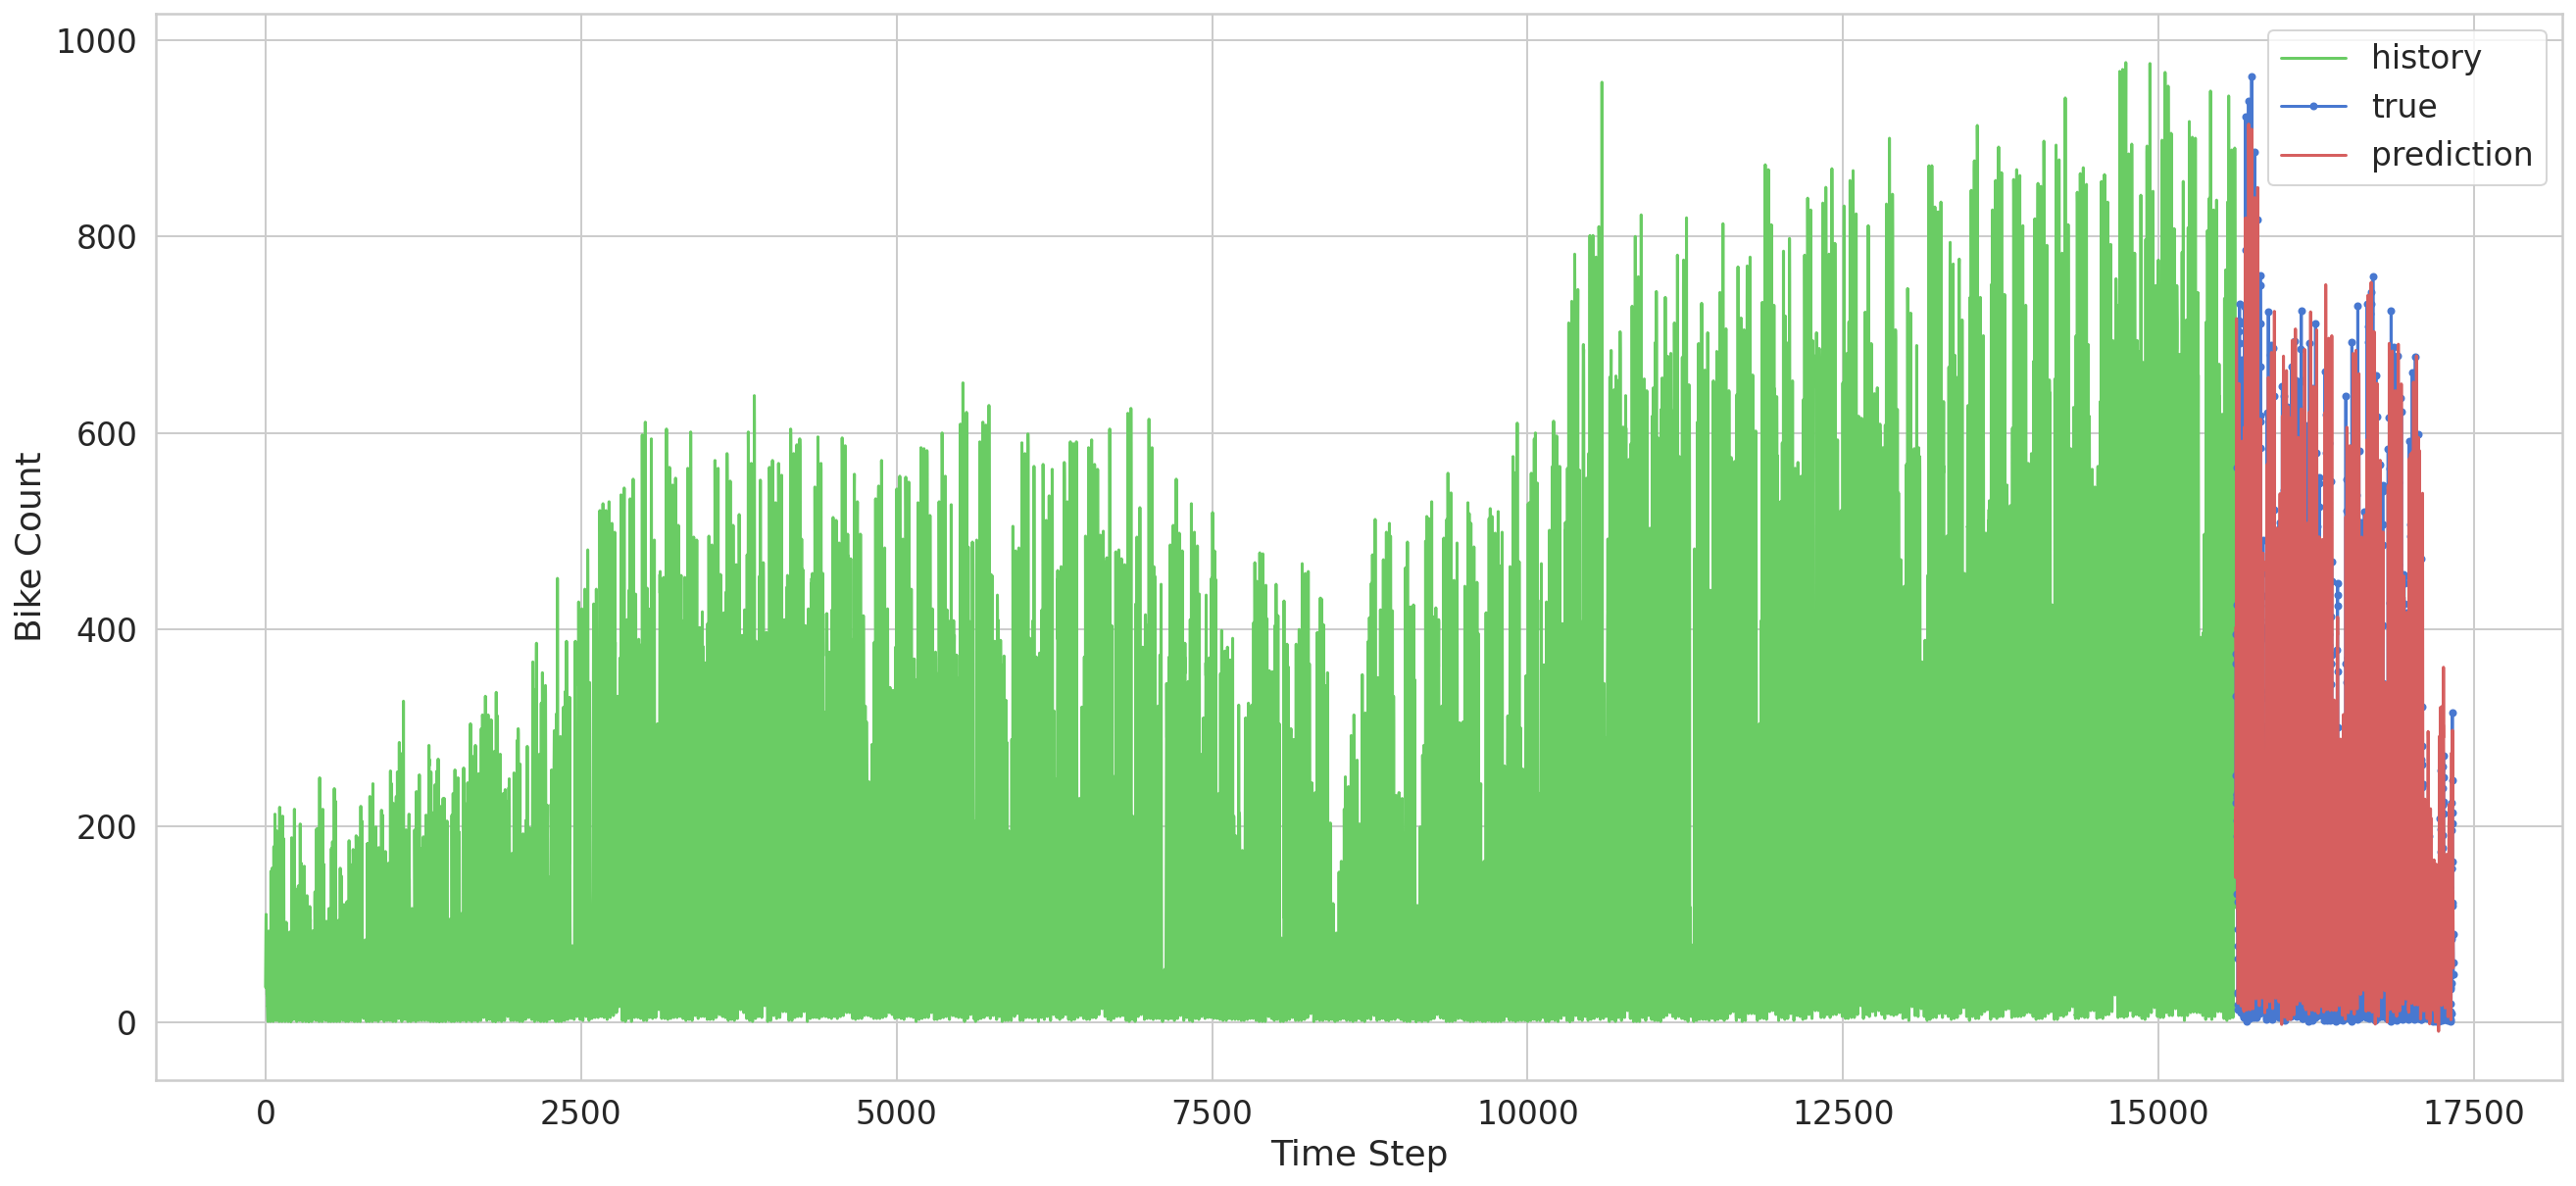

In [55]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

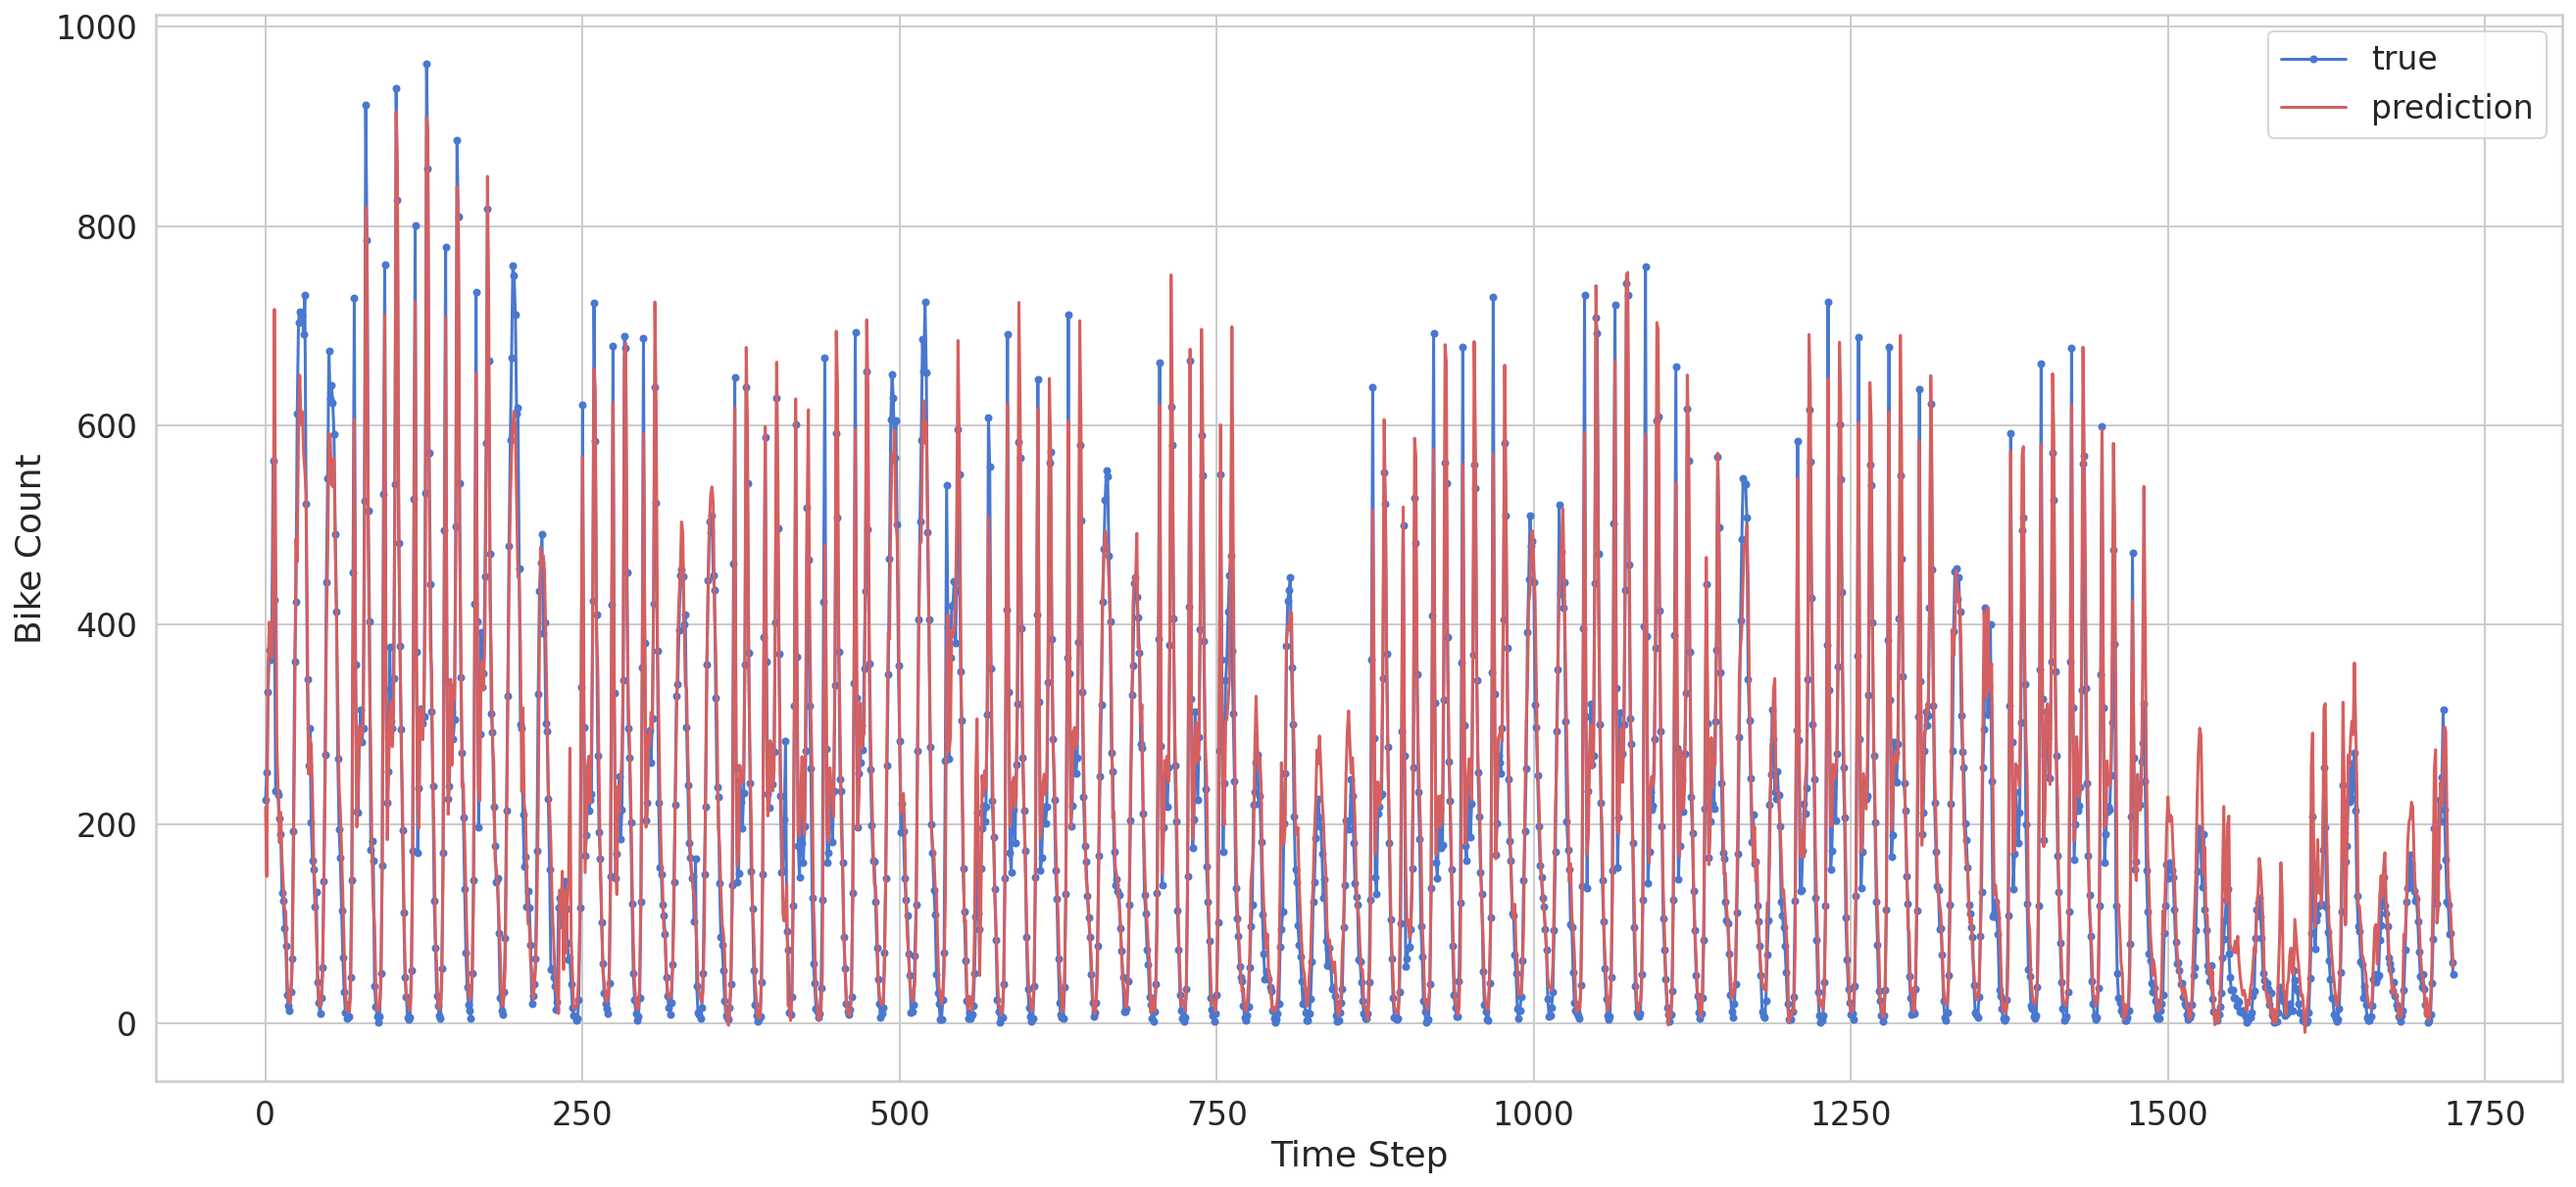

In [56]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [57]:
model = Sequential([
      #Bidirectional(LSTM(units=100,input_shape=(None, 2), return_sequences=True)),              
      LSTM(units=100,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
      Dropout(0.2),
      LSTM(units=100,return_sequences=True),
      LSTM(units=50,return_sequences=True),
      Dropout(0.2),
      Attention(),
      Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')

In [58]:
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/200
440/440 [==============================] - 17s 27ms/step - loss: 0.1910 - val_loss: 0.3947
Epoch 2/200
440/440 [==============================] - 11s 25ms/step - loss: 0.1518 - val_loss: 0.2062
Epoch 3/200
440/440 [==============================] - 10s 24ms/step - loss: 0.1319 - val_loss: 0.1455
Epoch 4/200
440/440 [==============================] - 11s 24ms/step - loss: 0.1158 - val_loss: 0.1904
Epoch 5/200
440/440 [==============================] - 10s 24ms/step - loss: 0.1011 - val_loss: 0.1658
Epoch 6/200
440/440 [==============================] - 10s 24ms/step - loss: 0.0778 - val_loss: 0.1230
Epoch 7/200
440/440 [==============================] - 11s 24ms/step - loss: 0.0624 - val_loss: 0.1057
Epoch 8/200
440/440 [==============================] - 11s 24ms/step - loss: 0.0509 - val_loss: 0.0924
Epoch 9/200
440/440 [==============================] - 11s 24ms/step - loss: 0.0473 - val_loss: 0.1043
Epoch 10/200
440/440 [==============================] - 11s 24ms/step - l

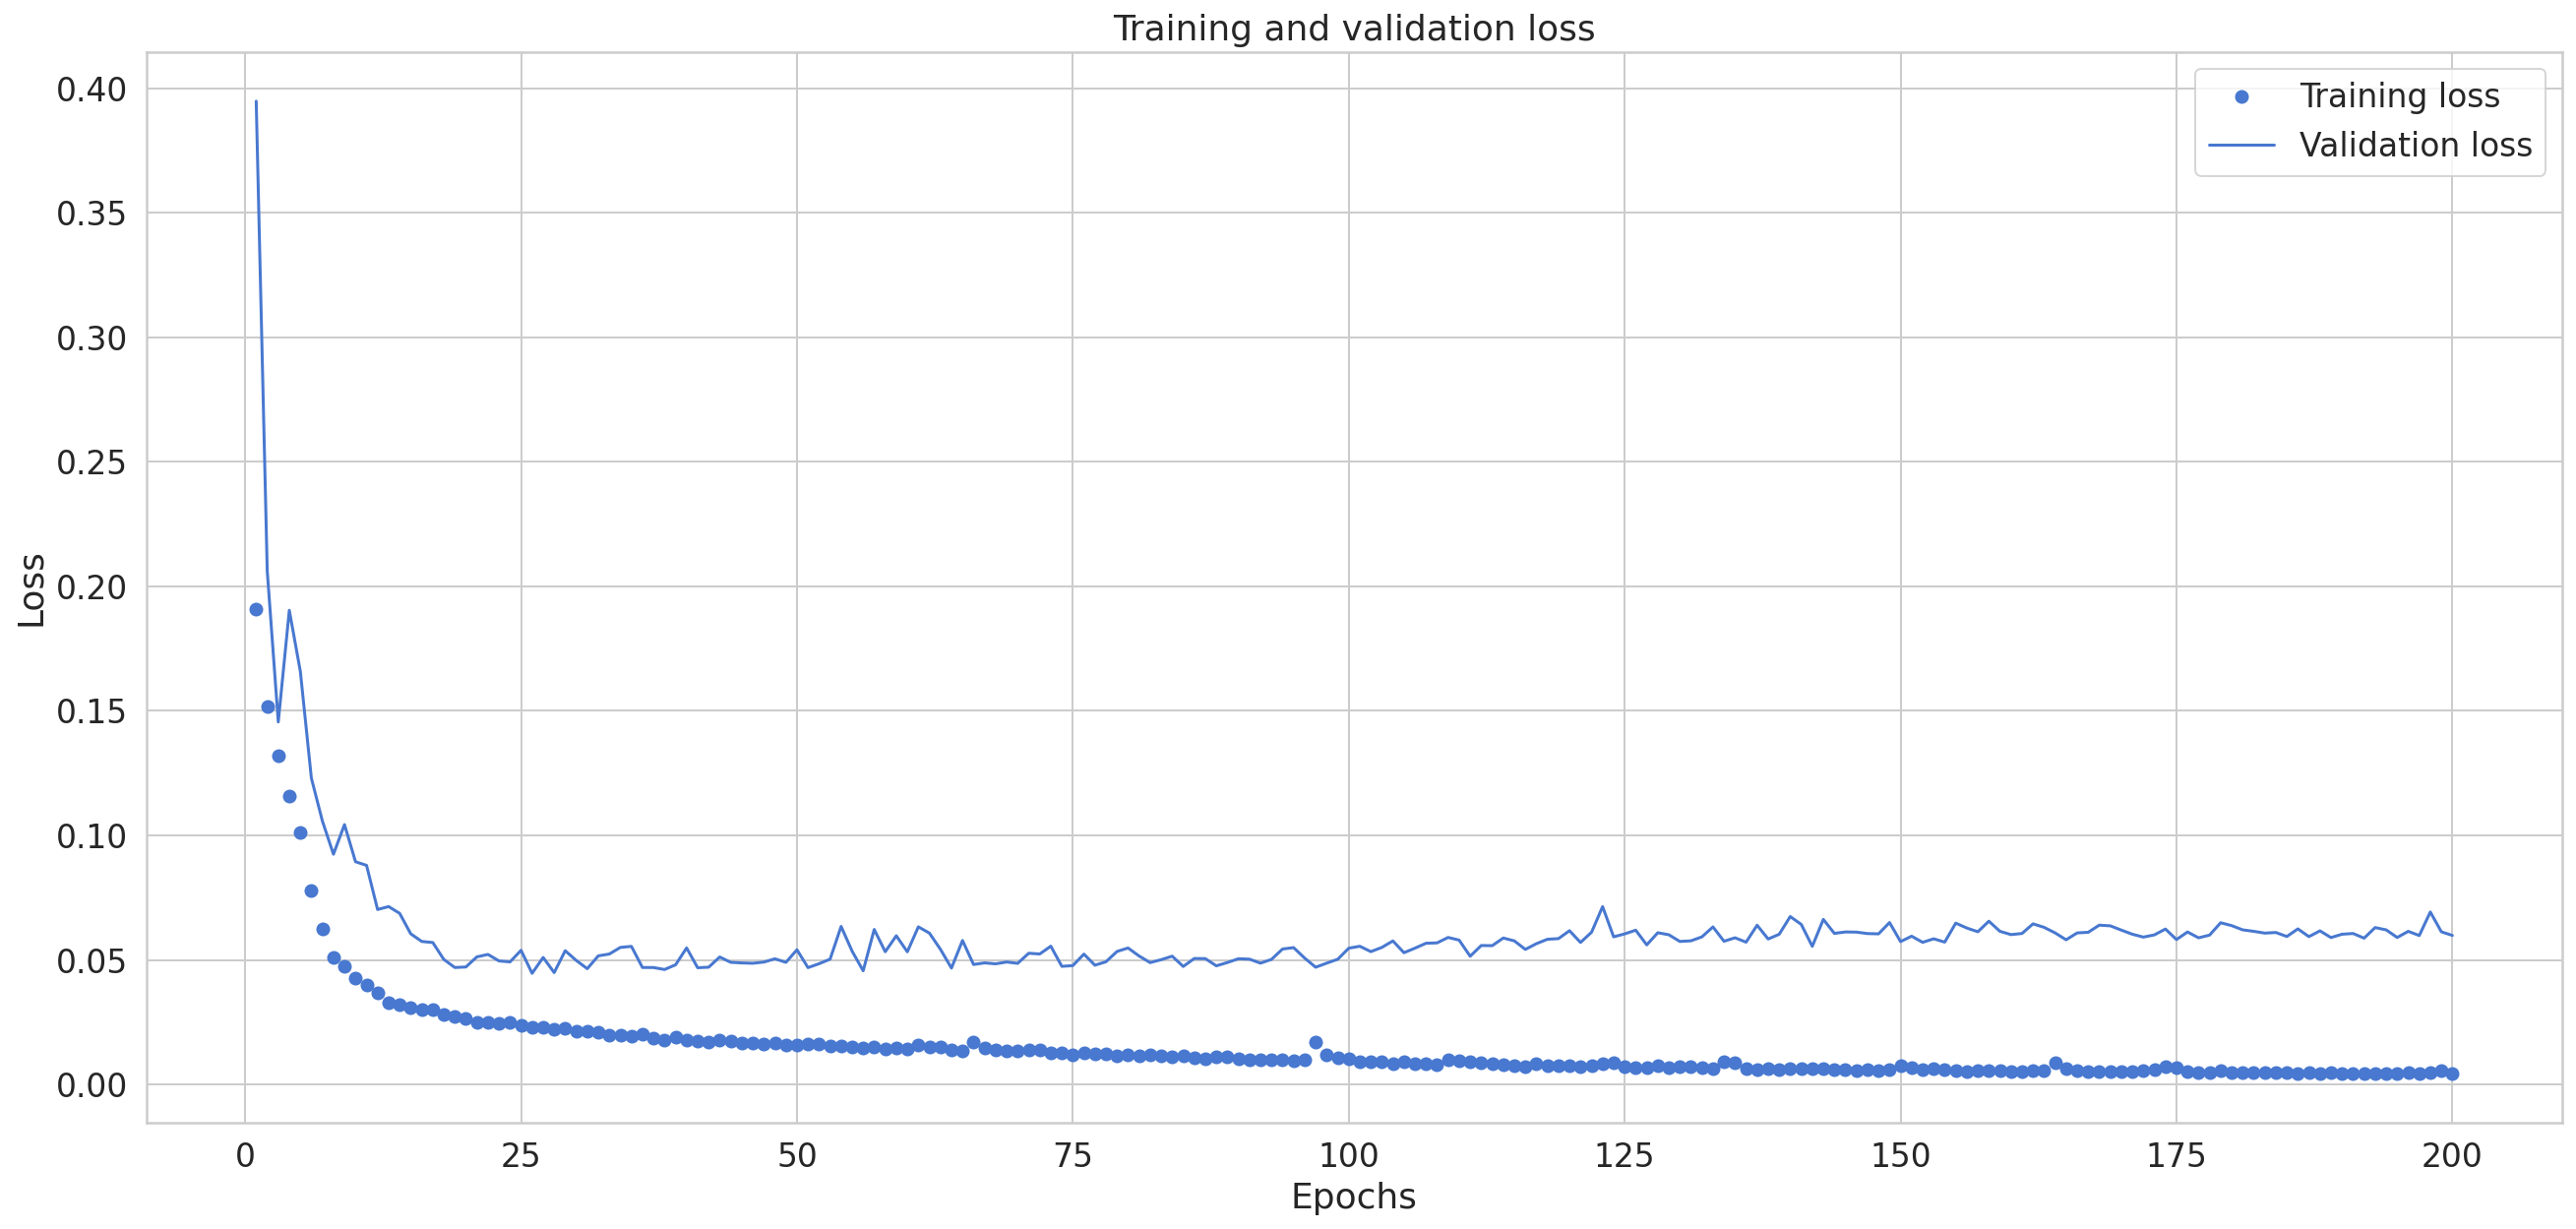

In [59]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [60]:
y_pred = model.predict(X_test)

54/54 [==============================] - 1s 8ms/step


In [61]:
train_mse = model.evaluate(X_train, y_train)
test_mse = model.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

54/54 [==============================] - 0s 8ms/step - loss: 0.0567
Train set MSE =  0.026650018990039825
Test set MSE =  0.056725118309259415


In [62]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

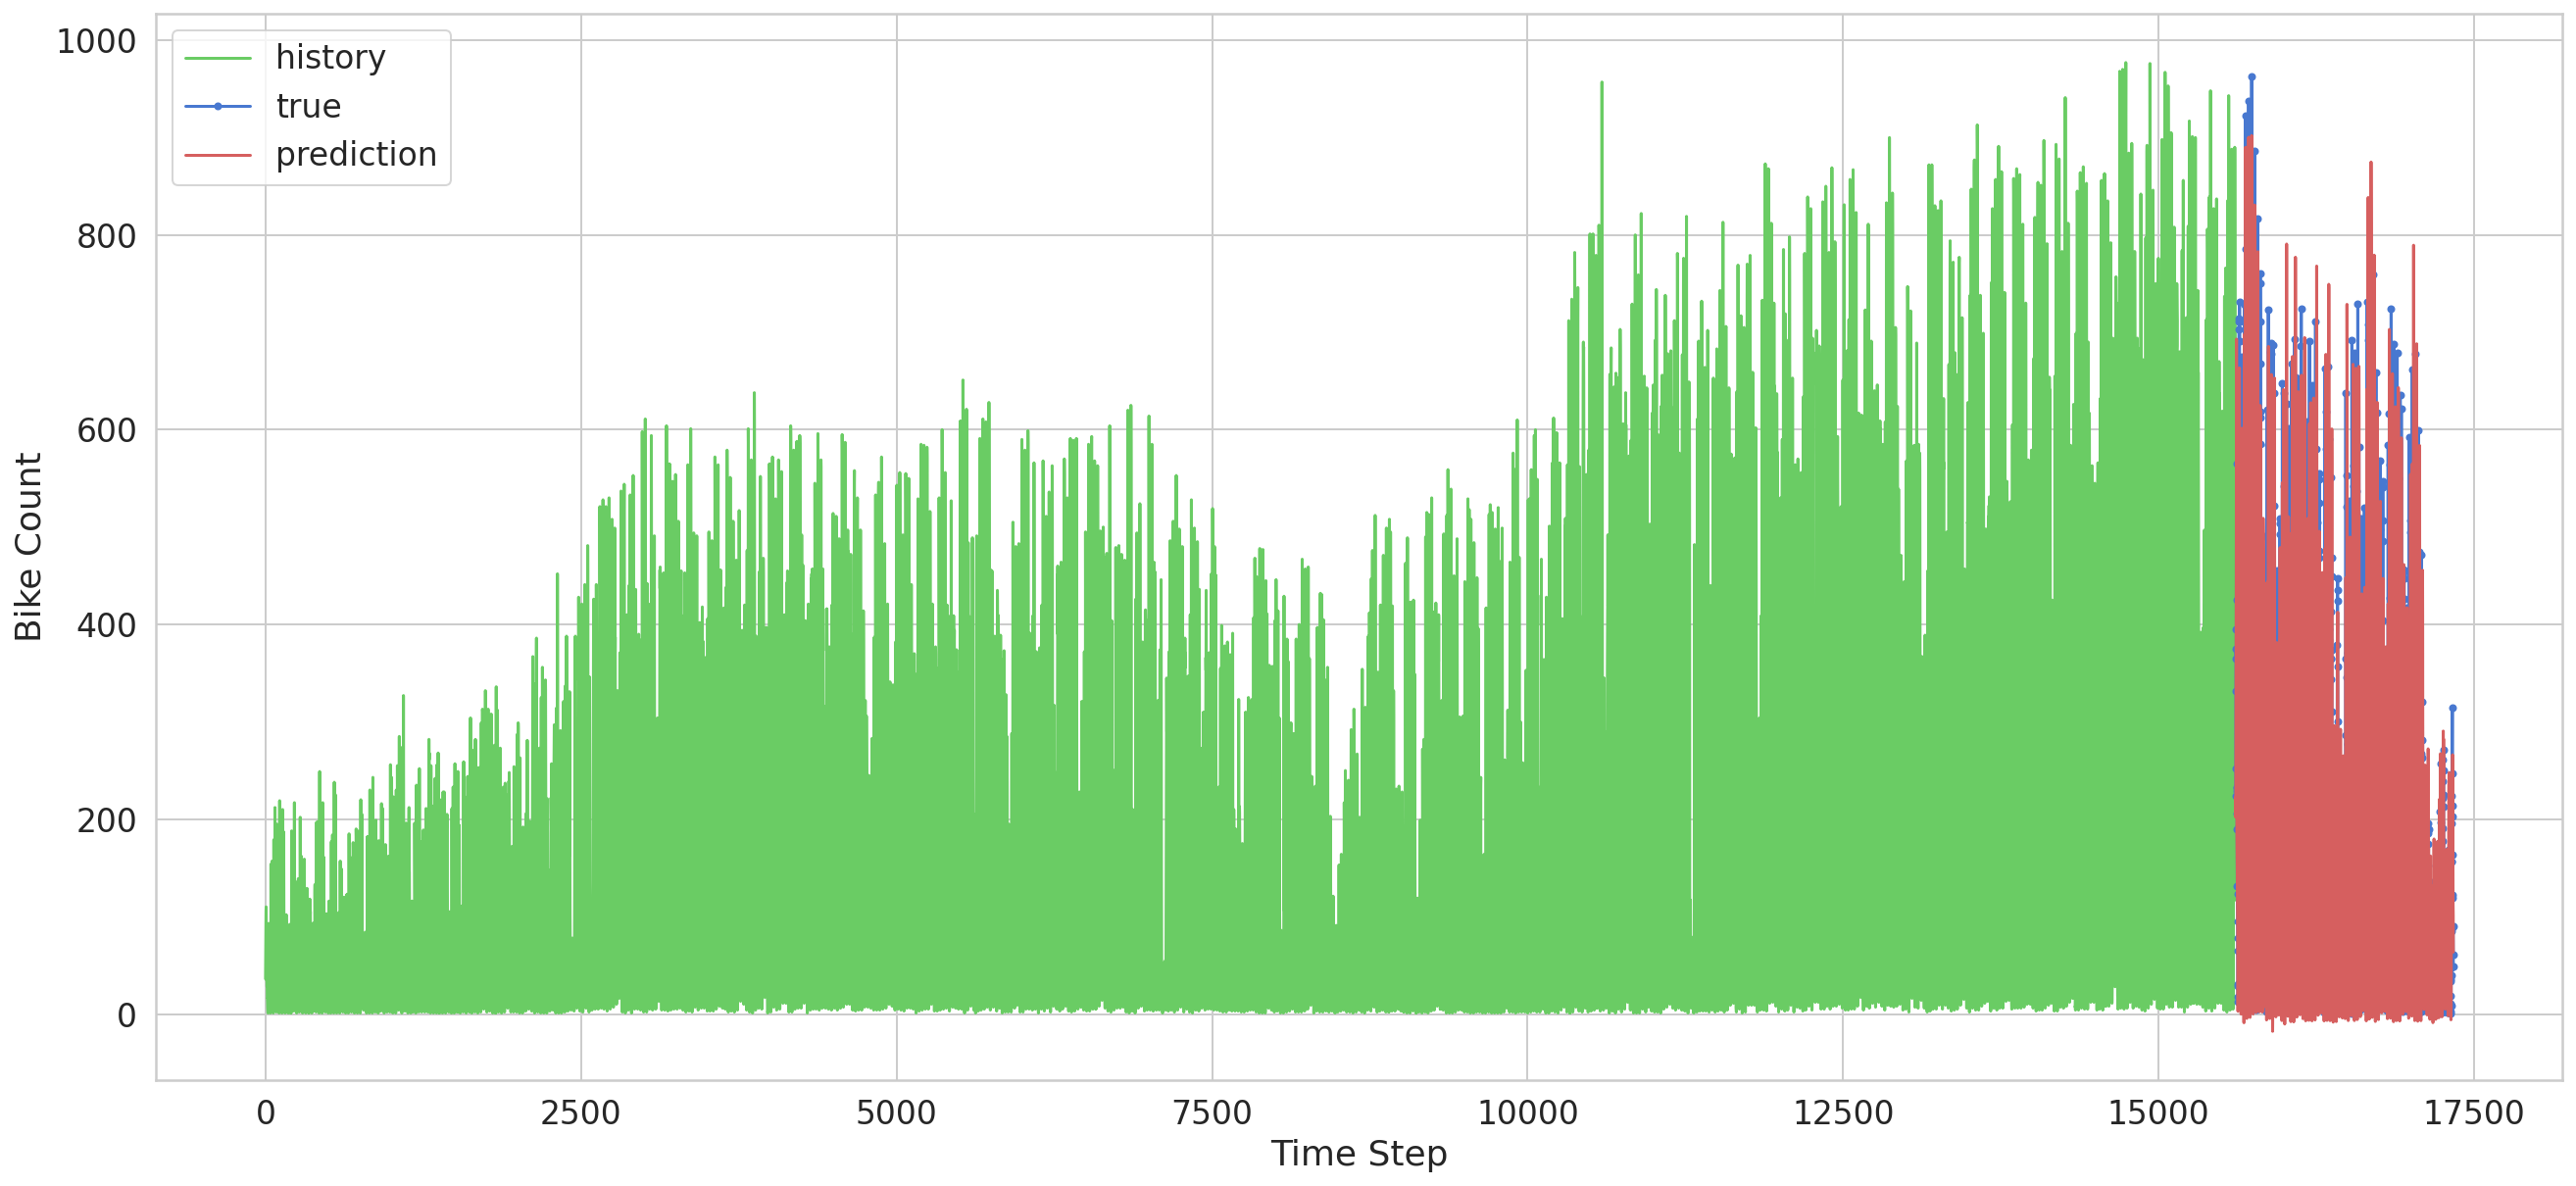

In [63]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

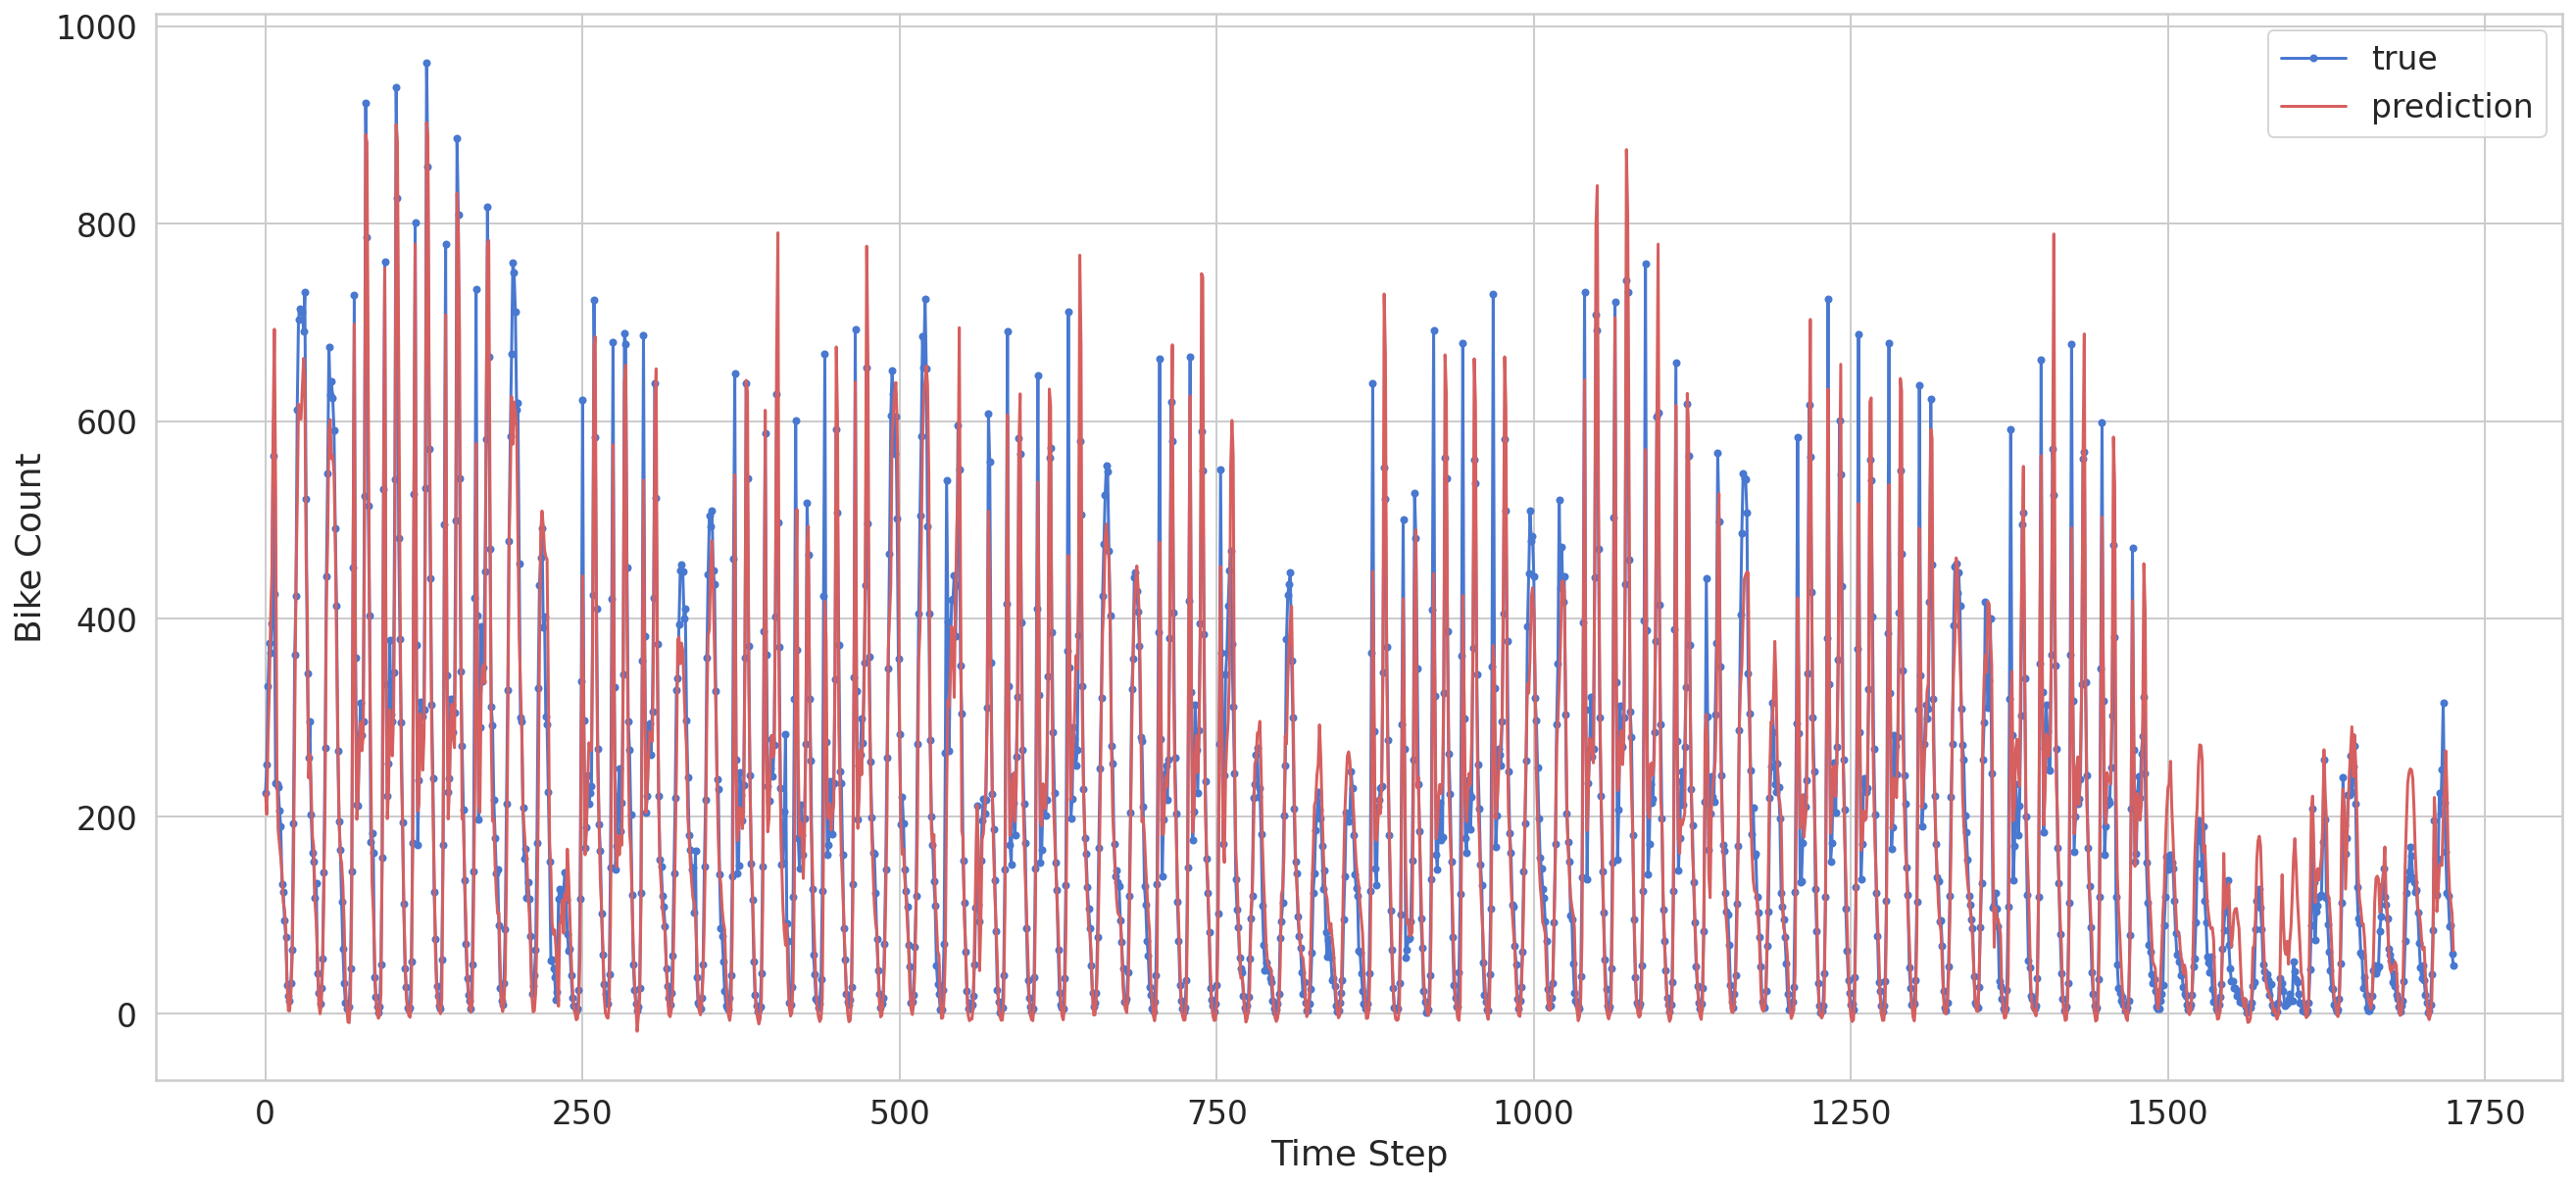

In [64]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();